### This script allows to create a map of the spatial distribution of precipitation averaged over 1983 to 2019 overlaid by cloud band days per year, over the South Pacific.

Before running this script, ensure that you have extracted the cloud bands and have the cloud band files ready. Edit config/config_analysis.yml as needed (eg: data location)

Acknowledgement: the work performed was done by using data from the Global Precipitation Climatology Project and from ERA5.

In [44]:
# Imports
import numpy as np
import os
import re
import string
import warnings

from netCDF4 import Dataset

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.util as cutil
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

try:
    import colorcet
except ImportError:
    colorcet = None

warnings.filterwarnings("ignore")


from cloudbandpy.figure_tools import set_fontsize
from cloudbandpy.io_utilities import load_ymlfile, load_data_from_saved_var_files, subset_latitudes, subset_longitudes
from cloudbandpy.misc import wrapTo180, wrapTo360
from cloudbandpy.time_utilities import create_list_of_dates, add_startend_datetime2config
from cloudbandpy.tracking import compute_density

In [45]:
config_file = os.path.join("../config", "config_analysis.yml")
config_clim = load_ymlfile(config_file, isconfigfile=True)
# Adapt configurations to this case
config_clim["data_localpath"] = "../data/"
# Make sure that the period for the cloud bands cover the same period as GPCP
config_clim["startdate"] = "19830101.00"
config_clim["enddate"] = "20191231.00"
add_startend_datetime2config(config_clim)
listofdates = create_list_of_dates(config_clim)
print(config_clim)

2023-07-04 16:05:52,078 - io_utilities.load_ymlfile - INFO: Configuration file loaded


{'domain': 'southPacific', 'startdate': '19830101.00', 'enddate': '20191231.00', 'saved_dirpath': './cloud_band_files/', 'data_localpath': '../data/', 'dir_figures': './cloud_band_figures/', 'load_saved_files': True, 'period_detection': 24.0, 'select_djfm': False, 'hemisphere': 'south', 'lon_west': 130, 'lon_east': 290, 'lat_north': 5, 'lat_south': -50, 'datetime_startdate': datetime.datetime(1983, 1, 1, 0, 0), 'datetime_enddate': datetime.datetime(2019, 12, 31, 0, 0)}


Set up directory where the files containing the cloud bands are

In [46]:
cloud_band_files_directory = "./cloud_band_files"

Load GPCP data

In [47]:
filename = "GPCPMON_L3_1983_2019_timemean.nc4"
file_path = os.path.join(config_clim["data_localpath"], filename)
ncfile = Dataset(file_path, "r")
lons = ncfile.variables["lon"][:]
gpcp_lats = ncfile.variables["lat"][:]
precip = ncfile.variables["sat_gauge_precip"][0]  # mm/day
# Add cyclic point
gpcp_precip, gpcp_lons = cutil.add_cyclic_point(precip, lons)

Setting up domains in a dictionnary

In [48]:
# Create latitudes and longitudes of 0.5 degree ERA5 data for the cloud bands
lons_globe = np.arange(0, 360, 0.5)
lats_globe = np.arange(90, -90.5, -0.5)

Load cloud bands and compute demnsity (number of cloud band day per year average over the period) for each domain

In [49]:
# Set up dictionnay that will contains longitudes and latitudes coordinates of each domain, the cloud bands and the density
data_cb4domains = {}
domains = ["southPacific", "northPacific", "southIndianOcean", "southAtlantic"]
for idom in domains:
    print(idom)
    # Load domain spcific config file for the coordinates of the domain
    config = load_ymlfile(os.path.join(f"../config/config_cbworkflow_{idom}.yml"), isconfigfile=True)
    config["saved_dirpath"] = cloud_band_files_directory
    config["load_saved_files"] = True
    config["startdate"] = config_clim["startdate"]
    config["enddate"] = config_clim["enddate"]
    add_startend_datetime2config(config)
    # if idom == "southAtlantic":
    # Get longitudes and latitudes for each domain
    _, lons = subset_longitudes(lons_globe, config["lon_west"], config["lon_east"])
    _, lats = subset_latitudes(lats_globe, config["lat_north"], config["lat_south"])
    if (
        idom == "southAtlantic"
    ):  # override for the south Atlantic domain since it goes accross the limit of ERA5 global domain (0-360)
        lons = np.arange(wrapTo180(config["lon_west"]), wrapTo180(config["lon_east"]), 0.5)
    list_of_cloud_bands = load_data_from_saved_var_files(config, varname="list_of_cloud_bands")
    # Compute density for the southern hemisphere
    _, density = compute_density(dates=listofdates, list_of_cloud_bands=list_of_cloud_bands)
    # # # Fill the dictionary for the current domain
    data_cb4domains[idom] = {
        "name": idom.lower().replace(" ", ""),
        "lats": lats,
        "lons": lons,
        "cloudbands": list_of_cloud_bands,
        "density": density,
        "config_dom": config,
    }

2023-07-04 16:05:52,178 - io_utilities.load_ymlfile - INFO: Configuration file loaded
2023-07-04 16:05:52,179 - io_utilities.load_data_from_saved_var_files - INFO: Load data from: 19830101.00 to 20191231.00


southPacific


FileNotFoundError: ./cloud_band_files/list_of_cloud_bands19830101.00-19831231.00-southPacific.bin not found.

Create figure

In [ ]:
# Mask precip when values == 0 to have white color for these values
gpcp = np.ma.masked_where(gpcp_precip == 0, gpcp_precip)

Change some figure parameters for dark background

In [ ]:
def set_presentation_style():
    # Set the figure facecolor and edgecolor to black
    mpl.rcParams['figure.facecolor'] = '#2A2A2A'
    mpl.rcParams['figure.edgecolor'] = '#2A2A2A'

    # Set the text color to white
    mpl.rcParams['text.color'] = 'white'

    # Set the tick color to white
    mpl.rcParams['xtick.color'] = 'white'
    mpl.rcParams['ytick.color'] = 'white'

    # Set the grid color to white
    mpl.rcParams['grid.color'] = 'white'

    # Set the axis spines color to white
    mpl.rcParams['axes.edgecolor'] = 'white'

    # Set the legend facecolor and edgecolor to black
    mpl.rcParams['legend.facecolor'] = '#2A2A2A'
    mpl.rcParams['legend.edgecolor'] = '#2A2A2A'

    # Set the savefig facecolor and edgecolor to black
    mpl.rcParams['savefig.facecolor'] = '#2A2A2A'
    mpl.rcParams['savefig.edgecolor'] = '#2A2A2A'
    mpl.rcParams['font.family'] = 'Futura'

    # plt.rc("font", **{"family": "sans-serif", "sans-serif": ["Futura"]})
    return

set_fontsize(19)
set_presentation_style()

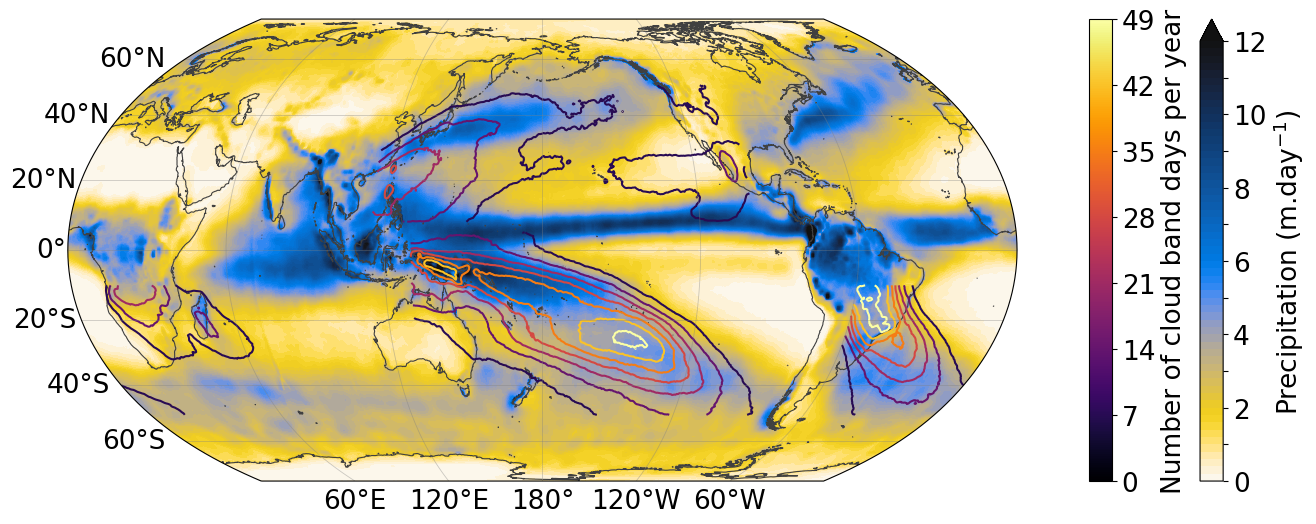

In [ ]:
# Global map of OLR year mean
set_fontsize(19)
LON_FORMAT = LongitudeFormatter(zero_direction_label=True, degree_symbol="")
LAT_FORMAT = LatitudeFormatter(degree_symbol="")
try:
    # better looking colorblind-proof colormap from colorcet
    cmap = mpl.cm.get_cmap("cet_CET_CBL2_r")
except:
    cmap = mpl.cm.get_cmap("viridis")
#
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.EqualEarth(central_longitude=180))

gpcp_contourf = ax.contourf(
    gpcp_lons,
    gpcp_lats,
    gpcp,
    transform=ccrs.PlateCarree(),
    levels=np.arange(0.0, 12.2, 0.2),
    cmap=cmap,
    extend="max",
)

for domain, data in data_cb4domains.items():
    domain_lons = data["lons"]
    domain_lats = data["lats"]
    domain_density = np.ma.masked_where(data["density"] == 0, data["density"])
    cs = ax.contour(
        domain_lons,
        domain_lats,
        domain_density,
        transform=ccrs.PlateCarree(),
        levels=range(0, 56, 7),
        linewidths=1.5,
        cmap="inferno",
    )

ax.coastlines("50m", color="#404040", linewidth=0.8)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.6, color="gray", alpha=0.4, linestyle="-")
gl.top_labels = False
gl.ylocator = mticker.FixedLocator([-60, -40, -20, 0, 20, 40, 60])
gl.xlocator = mticker.FixedLocator([60, 120, 180, -120, -60])

im_ratio = gpcp.shape[0] / gpcp.shape[1]
cbar = fig.colorbar(gpcp_contourf, orientation="vertical", ticks=np.arange(0, 13, 1), fraction=0.047 * im_ratio)
cbar.ax.set_yticklabels([el if el % 2 == 0 else "" for el in range(13)])
cbar.set_label(r"Precipitation (m.day$^{-1}$)")

norm = mpl.colors.Normalize(vmin=cs.cvalues.min(), vmax=cs.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cs.cmap)
density_colorbar = fig.colorbar(sm, orientation="vertical", ticks=np.arange(0, 56, 7), fraction=0.047 * im_ratio)
density_colorbar.set_label(r"Number of cloud band days per year")

plt.show()
# fig.savefig(
#     f"map_world_precip_GPCP_avg_{config_clim['datetime_startdate'].year}-{config_clim['datetime_enddate'].year}_cloudbands7days.png",
#     dpi=300,
#     bbox_inches="tight",
# )

Focus on the South Pacific

In [ ]:
south_pacific_data = data_cb4domains["southPacific"]

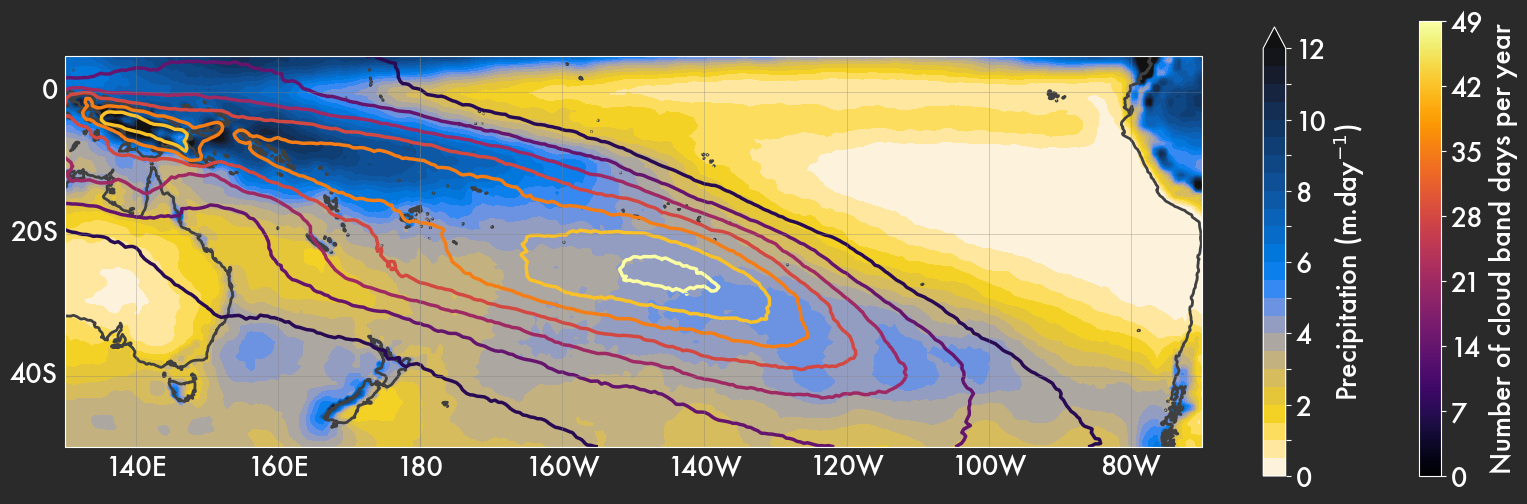

In [50]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)}, figsize=(19*(5/6), 7*(5/6)))
domain = "southpacific"
gpcp_contourf = ax.contourf(
    gpcp_lons,
    gpcp_lats,
    gpcp,
    transform=ccrs.PlateCarree(),
    levels=np.arange(0.0, 12.5, .5),
    cmap=cmap,
    extend="max",
)
domain_lons = south_pacific_data["lons"]
domain_lats = south_pacific_data["lats"]
domain_density = np.ma.masked_where(south_pacific_data["density"] == 0, south_pacific_data["density"])
ax.coastlines("50m", color="#404040", linewidth=2)
cmap_contour = "inferno"
cs = ax.contour(
    domain_lons,
    domain_lats,
    domain_density,
    levels=range(0, 56, 7),
    linewidths=2.5,
    cmap="inferno",
    transform=ccrs.PlateCarree(),
)

ax.set_extent(
    (
        south_pacific_data["config_dom"]["lon_west"],
        south_pacific_data["config_dom"]["lon_east"],
        south_pacific_data["config_dom"]["lat_south"],
        south_pacific_data["config_dom"]["lat_north"],
    ),
    crs=ccrs.PlateCarree(),
)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.6, color="gray", alpha=0.4, linestyle="-")
gl.top_labels = False
gl.right_labels = False
gl.ylocator = mticker.MultipleLocator(20)
gl.xlocator = mticker.MultipleLocator(20)
gl.xformatter = LON_FORMAT
gl.yformatter = LAT_FORMAT

# First color bar
im_ratio = gpcp.shape[0] / gpcp.shape[1]
cbar = fig.colorbar(gpcp_contourf, orientation="vertical", ticks=np.arange(0, 13, 1), fraction=0.047 * im_ratio)
cbar.ax.set_yticklabels([el if el % 2 == 0 else "" for el in range(13)])
cbar.set_label(r"Precipitation (m.day$^{-1}$)", color="white")
cbar.ax.xaxis.set_tick_params(color="white")

# Second color bar
norm = mpl.colors.Normalize(vmin=cs.cvalues.min(), vmax=cs.cvalues.max())
sm = plt.cm.ScalarMappable(norm=norm, cmap=cs.cmap)
cax = fig.add_axes([0.98, 0.11, 0.014, 0.78])
density_colorbar = fig.colorbar(
    sm, cax=cax, orientation="vertical", ticks=np.arange(0, 63, 7), fraction=0.047 * im_ratio
)
density_colorbar.set_label(r"Number of cloud band days per year", color="white")

density_colorbar.ax.xaxis.set_tick_params(color="white")

plt.show()

# fig.savefig(
#     f"map_SouthPacific_precip_GPCP_avg_{config_clim['datetime_startdate'].year}-{config_clim['datetime_enddate'].year}_cloudbands7days.png",
#     dpi=300,
#     bbox_inches="tight",
# )

Subplots of precipitation overlayed by mean number of cloud bands per year
-> must be adapted for the South Atlantic basin

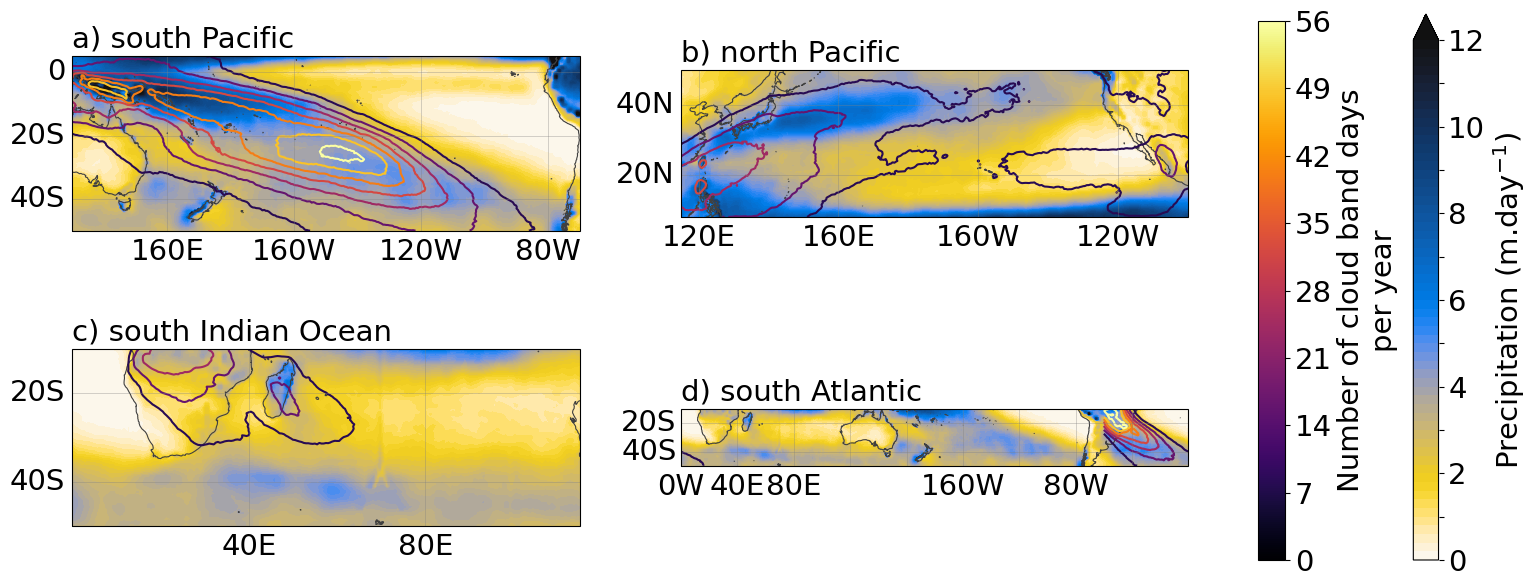

In [ ]:
set_fontsize(21)
# for panel numbering
alphabet = list(string.ascii_lowercase)

fig, axs = plt.subplots(
    ncols=2, nrows=2, subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)}, figsize=(18, 7) # change central_longitude to 0 for south Atlantic
)
for idx, (ax, (domain, data)) in enumerate(zip(axs.flat, data_cb4domains.items())):
    gpcp_contourf = ax.contourf(
        gpcp_lons,
        gpcp_lats,
        gpcp,
        transform=ccrs.PlateCarree(),
        levels=np.arange(0.0, 12.2, 0.2),
        cmap=cmap,
        extend="max",
    )
    domain_lons = data["lons"]
    domain_lats = data["lats"]
    domain_density = np.ma.masked_where(data["density"] == 0, data["density"])
    ax.coastlines("50m", color="#404040", linewidth=0.8)
    cmap_contour = "inferno"
    cs = ax.contour(
        domain_lons,
        domain_lats,
        domain_density,
        levels=range(0, 56, 7),
        linewidths=1.5,
        cmap="inferno",
        transform=ccrs.PlateCarree(),
    )
    if domain == "southAtlantic":
        ax.set_ylim([data["config_dom"]["lat_south"], data["config_dom"]["lat_north"]])
        ax.set_extent(
            (
                wrapTo180(data["config_dom"]["lon_west"]),
                wrapTo180(data["config_dom"]["lon_east"]),
                data["config_dom"]["lat_south"],
                data["config_dom"]["lat_north"],
            ),
            crs=ccrs.PlateCarree(),
        )
    else:
        ax.set_extent(
            (
                data["config_dom"]["lon_west"],
                data["config_dom"]["lon_east"],
                data["config_dom"]["lat_south"],
                data["config_dom"]["lat_north"],
            ),
            crs=ccrs.PlateCarree(),
        )
    split_words_domain = re.split("(?=[A-Z])", domain)
    ax.set_title(f"{alphabet[idx]}) {' '.join(split_words_domain)}", loc="left")
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.6, color="gray", alpha=0.4, linestyle="-")
    gl.top_labels = False
    gl.right_labels = False
    gl.ylocator = mticker.MultipleLocator(20)
    if idom == "northPacific" or "northPacific":
        gl.xlocator = mticker.MultipleLocator(40)
    else:
        gl.xlocator = mticker.MultipleLocator(20)
    gl.xformatter = LON_FORMAT
    gl.yformatter = LAT_FORMAT

cax = fig.add_axes([0.87, 0.11, 0.014, 0.78])
cbar = fig.colorbar(gpcp_contourf, orientation="vertical", ticks=np.arange(0, 13, 1), cax=cax)
cbar.ax.set_yticklabels([el if el % 2 == 0 else "" for el in range(13)])
cbar.set_label(r"Precipitation (m.day$^{-1}$)")

norm = mpl.colors.Normalize(vmin=0, vmax=56)
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap_contour)
density_colorbar = fig.colorbar(sm, ax=axs.ravel().tolist(), ticks=np.arange(0, 63, 7))
density_colorbar.set_label("Number of cloud band days"+"\n"+"per year")


plt.show()

# fig.savefig(
#     f"map_4domains_precip_GPCP_avg_{config_clim['datetime_startdate'].year}-{config_clim['datetime_enddate'].year}_cloudbands7days.png",
#     dpi=300,
#     bbox_inches="tight",
# )